In [1]:
# install necessary
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.9 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# import 
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, InterpolationMode, RandomHorizontalFlip, RandomVerticalFlip, RandomAutocontrast, PILToTensor, ToPILImage, Compose
import torchvision.transforms.functional as TF
from collections import OrderedDict
import wandb

In [3]:
!nvidia-smi

Fri Nov 17 12:59:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

In [5]:
import segmentation_models_pytorch as smp

## Dataset

In [6]:
class MyDataSet(Dataset):
    def __init__(self, train_path, gt_path, transform = None):
        self.train_path = train_path
        self.gt_path = gt_path
        self.images = os.listdir(train_path)
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = os.path.join(self.train_path, self.images[index])
        label_path = os.path.join(self.gt_path, self.images[index])
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        
        image = TF.pil_to_tensor(image)
        label = TF.pil_to_tensor(label)
        
#         seed = random.randint(0, 100000)
#         random.seed(seed)
#         torch.manual_seed(seed)
        
#         if torch.cuda.is_available():
#             torch.backends.cudnn.deterministic = True
#             torch.cuda.manual_seed_all(seed)
        
        if self.transform is not None:
            image = self.transform(image)/255
            label = self.transform(label)/255
            
        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            label = TF.hflip(label)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            label = TF.vflip(label)
            
        # Random adjust contrast
        if random.random() > 0.5:
            image = TF.adjust_contrast(image, 1.5)
        
        label = torch.where(label>0.65, 1.0, 0.0)
        label[2, :, :] = 0.0001
        label = torch.argmax(label, 0).type(torch.int64)
        
        return image, label
    def __len__(self):
        return len(self.images)

In [7]:
train_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
gt_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

my_transform = Compose(
    [Resize((800, 1120))]
)

my_dataset = MyDataSet(train_path=train_path, gt_path=gt_path, transform=my_transform)

train_size = 0.8
valid_size = 0.2
batch_size = 4

train_set, valid_set = random_split(
    my_dataset, 
    [int(train_size * len(my_dataset)), int(valid_size * len(my_dataset))]
)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

## Train

In [8]:
# Number of epoch
epochs = 16

# Hyperparameters for training 
learning_rate =4e-4
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"

In [9]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

In [10]:
def train(train_dataloader, valid_dataloader,learning_rate_scheduler, epoch, display_step):
    print(f"Start epoch #{epoch+1}, learning rate for this epoch: {learning_rate_scheduler.get_last_lr()}")
    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets.long())
        loss.backward()

        # Apply gradients
        optimizer.step()
        
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            test_output = model(data)
            test_loss = loss_function(test_output, target)
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [11]:
model = smp.UnetPlusPlus(classes = 3)

model = nn.DataParallel(model)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


DataParallel(
  (module): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          

In [12]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=learning_rate),
])

learing_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.6)

In [13]:
save_model(model, optimizer, checkpoint_path)

In [14]:
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key = "1658d378d091cf8659e37004bc727f76b3de8356",
)
wandb.init(
    project = "NewPolypSegment"
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: duongchinh29062003 (chinh). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231117_130008-ktmz2i6c
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run iconic-capybara-10
wandb: ⭐️ View project at https://wandb.ai/chinh/NewPolypSegment
wandb: 🚀 View run at https://wandb.ai/chinh/NewPolypSegment/runs/ktmz2i6c


In [15]:
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              learing_rate_scheduler, epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    learing_rate_scheduler.step()
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch*4})

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Start epoch #1, learning rate for this epoch: [0.0004]
Train Epoch: 1 [200/800 (25.0%)]	Loss: 0.3239
Train Epoch: 1 [400/800 (50.0%)]	Loss: 0.1765
Train Epoch: 1 [600/800 (75.0%)]	Loss: 0.1071
Train Epoch: 1 [800/800 (100.0%)]	Loss: 0.1027
Done epoch #1, time for this epoch: 348.34758710861206s
Start epoch #2, learning rate for this epoch: [0.0004]
Train Epoch: 2 [200/800 (25.0%)]	Loss: 0.0711
Train Epoch: 2 [400/800 (50.0%)]	Loss: 0.1429
Train Epoch: 2 [600/800 (75.0%)]	Loss: 0.0997
Train Epoch: 2 [800/800 (100.0%)]	Loss: 0.0545
Done epoch #2, time for this epoch: 329.1474287509918s
Start epoch #3, learning rate for this epoch: [0.0004]
Train Epoch: 3 [200/800 (25.0%)]	Loss: 0.0714
Train Epoch: 3 [400/800 (50.0%)]	Loss: 0.0414
Train Epoch: 3 [600/800 (75.0%)]	Loss: 0.0883
Train Epoch: 3 [800/800 (100.0%)]	Loss: 0.1150
Done epoch #3, time for this epoch: 329.5734233856201s
Start epoch #4, learning rate for this epoch: [0.0004]
Train Epoch: 4 [200/800 (25.0%)]	Loss: 0.2206
Train Epoch: 

## Plot

In [16]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

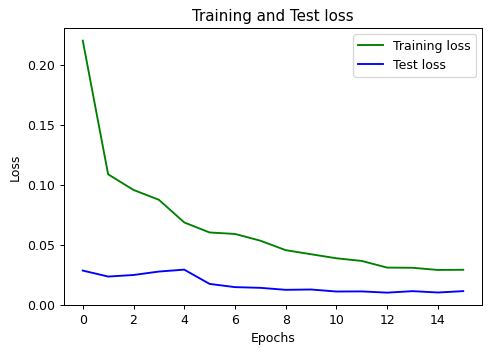

In [17]:
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize results

In [18]:
for i, (data, label) in enumerate(train_dataloader):
    img = data
    mask = label
    break

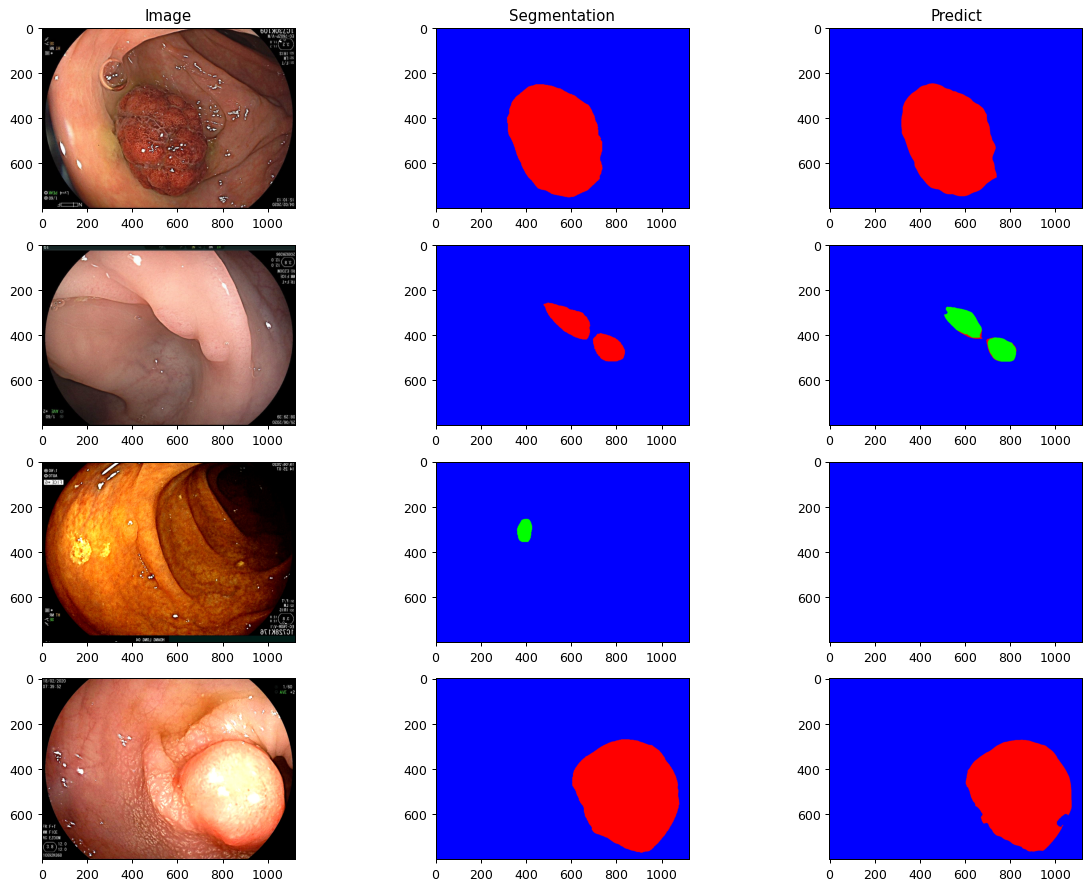

In [19]:
fig, arr = plt.subplots(4, 3, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(4):
    arr[i][0].imshow(img[i].permute(1, 2, 0))
    arr[i][1].imshow(F.one_hot(mask[i]).float())
    arr[i][2].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

## Create submission

In [20]:
transform = Compose([Resize((800, 1120)),PILToTensor()])

In [21]:
class UNetTestDataClass(Dataset):
    def __init__(self, images_path, transform):
        super(UNetTestDataClass, self).__init__()
        
        images_list = os.listdir(images_path)
        images_list = [images_path+i for i in images_list]
        
        self.images_list = images_list
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.images_list[index]
        data = Image.open(img_path)
        h = data.size[1]
        w = data.size[0]
        data = self.transform(data) / 255        
        return data, img_path, h, w
    
    def __len__(self):
        return len(self.images_list)

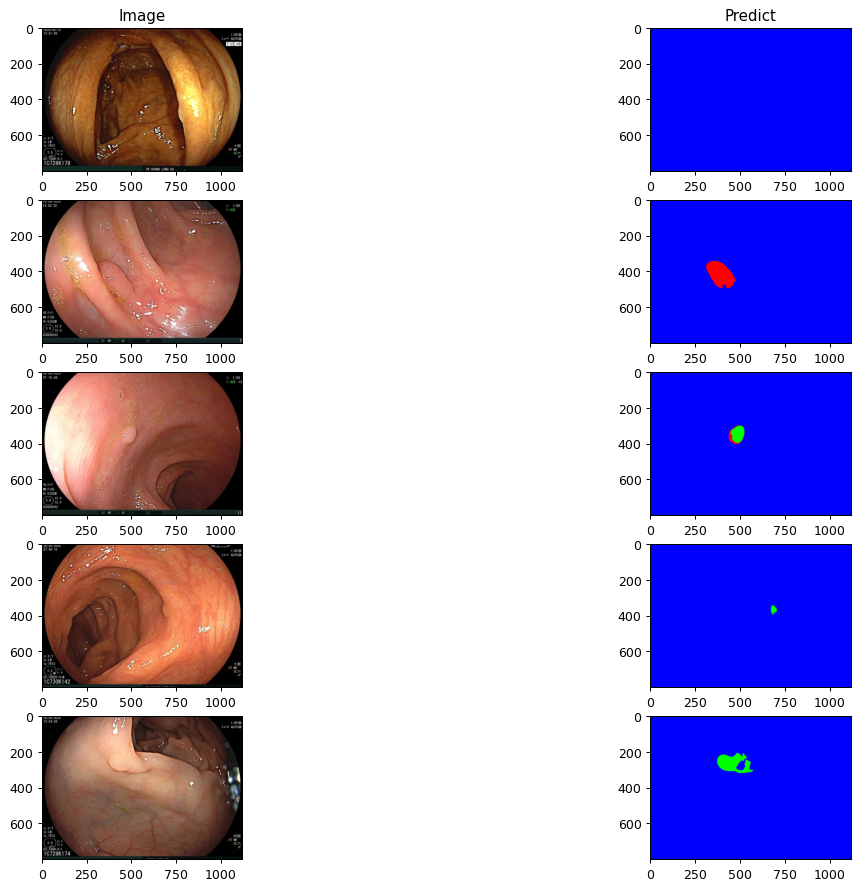

In [22]:
path = '/kaggle/input/bkai-igh-neopolyp/test/test/'
unet_test_dataset = UNetTestDataClass(path, transform)
test_dataloader = DataLoader(unet_test_dataset, batch_size=8, shuffle=True)

for i, (data, path, h, w) in enumerate(test_dataloader):
    img = data
    break
    
fig, arr = plt.subplots(5, 2, figsize=(16, 12))
arr[0][0].set_title('Image');
arr[0][1].set_title('Predict');

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(5):
    arr[i][0].imshow(img[i].permute(1, 2, 0));
    arr[i][1].imshow(F.one_hot(torch.argmax(predict[i], 0).cpu()).float())

In [23]:
model.eval()
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")
for _, (img, path, H, W) in enumerate(test_dataloader):
    a = path
    b = img
    h = H
    w = W
    
    with torch.no_grad():
        predicted_mask = model(b)
    for i in range(len(a)):
        image_id = a[i].split('/')[-1].split('.')[0]
        filename = image_id + ".png"
        mask2img = Resize((h[i].item(), w[i].item()), interpolation=InterpolationMode.NEAREST)(ToPILImage()(F.one_hot(torch.argmax(predicted_mask[i], 0)).permute(2, 0, 1).float()))
        mask2img.save(os.path.join("/kaggle/working/predicted_masks/", filename))

In [24]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'submission.csv', index=False)

/kaggle/working/predicted_masks/50534bca540e24f489284b8e6953ad88.png
/kaggle/working/predicted_masks/7b5df7cdf3f33c3ca4d5060a633a8d5b.png
/kaggle/working/predicted_masks/395e56a6d9ba9d45c3dbc695325ded46.png
/kaggle/working/predicted_masks/4e8bfb905b78a91391adc0bb223c4eaf.png
/kaggle/working/predicted_masks/c695325ded465efde988dfb96d081533.png
/kaggle/working/predicted_masks/cf6644589e532a9ee954f81faedbce39.png
/kaggle/working/predicted_masks/39dda50f954ba59c7de13a35276a4764.png
/kaggle/working/predicted_masks/677a6b1f2c6d40b3bbba8f6c704801b3.png
/kaggle/working/predicted_masks/45b21960c94b0aab4c024a573c692195.png
/kaggle/working/predicted_masks/7f0019f7e6af7d7147763bdfb928d788.png
/kaggle/working/predicted_masks/e5e8f14e1e0ae936de314f2d95e6c487.png
/kaggle/working/predicted_masks/3c84417fda8019410b1fcf0625f608b4.png
/kaggle/working/predicted_masks/998906d3694abb47953b0e4909384b57.png
/kaggle/working/predicted_masks/d5060a633a8d5b2b2b55157b7781e2c7.png
/kaggle/working/predicted_masks/34